<a href="https://colab.research.google.com/github/abbyWoot/AML/blob/master/AML_Project4_JiahuiWu.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##**Advanced Machine Learning Project4**

@student: Jiahui Wu Abby

The hourly data set contains the PM2.5 data of US Embassy in Beijing, and meteorological data from Beijing Capital International Airport.
PM2.5 refers to atmospheric particulate matter(PM) that have a diameter of less than 2.5 micrometers, which is about 3% the diameter of a human hair.

In [0]:
#Set Up. 
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os
import tarfile
import urllib
import csv

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline 
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "unsupervised_learning"

def save_fig(fig_id, tight_layout=True):
    path = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID, fig_id + ".png")
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

In [0]:
#load data using Pandas
DOWNLOAD_ROOT = "https://archive.ics.uci.edu/ml/machine-learning-databases/"
PM25_PATH = os.path.join("00381", "PRSA_data_2010.1.1-2014.12.31.csv")
PM25_URL = DOWNLOAD_ROOT + "00381/PRSA_data_2010.1.1-2014.12.31.csv"


In [0]:
import pandas as pd

def load_pm25_data():
  csv=pd.read_csv(PM25_URL)
  return csv

Now let's take a look at the top five rows using the DataFrames' head() method

In [42]:
pm25 = load_pm25_data()
print(pm25)
pm25.head()

          No  year  month  day  hour  pm2.5  ...  TEMP    PRES  cbwd     Iws  Is  Ir
0          1  2010      1    1     0    NaN  ... -11.0  1021.0    NW    1.79   0   0
1          2  2010      1    1     1    NaN  ... -12.0  1020.0    NW    4.92   0   0
2          3  2010      1    1     2    NaN  ... -11.0  1019.0    NW    6.71   0   0
3          4  2010      1    1     3    NaN  ... -14.0  1019.0    NW    9.84   0   0
4          5  2010      1    1     4    NaN  ... -12.0  1018.0    NW   12.97   0   0
...      ...   ...    ...  ...   ...    ...  ...   ...     ...   ...     ...  ..  ..
43819  43820  2014     12   31    19    8.0  ...  -2.0  1034.0    NW  231.97   0   0
43820  43821  2014     12   31    20   10.0  ...  -3.0  1034.0    NW  237.78   0   0
43821  43822  2014     12   31    21   10.0  ...  -3.0  1034.0    NW  242.70   0   0
43822  43823  2014     12   31    22    8.0  ...  -4.0  1034.0    NW  246.72   0   0
43823  43824  2014     12   31    23   12.0  ...  -3.0  1034.0   

,No,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir
0,1,2010,1,1,0,NaN,-21,-11.0,1021.0,NW,1.79,0,0
1,2,2010,1,1,1,NaN,-21,-12.0,1020.0,NW,4.92,0,0
2,3,2010,1,1,2,NaN,-21,-11.0,1019.0,NW,6.71,0,0
3,4,2010,1,1,3,NaN,-21,-14.0,1019.0,NW,9.84,0,0
4,5,2010,1,1,4,NaN,-20,-12.0,1018.0,NW,12.97,0,0


There are 13 attributes: No, year, month, day, hour, pm2.5, DEWP, TEMP, PRES, cbwd, Iws, Is, Ir

*   No: Number of records
*   PM2.5: PM2.5 percentage (ug/m^3)
*   DEWP: Dew point temperature, the temperature at which the air can no longer "hold" all of the water vapor which is mixed with it, and some of the water vapor must condense into liquid water. The dew point is always lower than (or equal to) the air temperature.
*   TEMP: Air Temperature
*   PRES: Atmospheric pressure (hPa) 
*   cbwd: Combined wind direction
*   Iws: Cumulated wind speed (m/s) 
*   Is: Cumulated hours of snow
*   Ir: Cumulated hours of rain (mm)


In [43]:
pm25.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43824 entries, 0 to 43823
Data columns (total 13 columns):
No       43824 non-null int64
year     43824 non-null int64
month    43824 non-null int64
day      43824 non-null int64
hour     43824 non-null int64
pm2.5    41757 non-null float64
DEWP     43824 non-null int64
TEMP     43824 non-null float64
PRES     43824 non-null float64
cbwd     43824 non-null object
Iws      43824 non-null float64
Is       43824 non-null int64
Ir       43824 non-null int64
dtypes: float64(4), int64(8), object(1)
memory usage: 4.3+ MB


Above info() method showed us that there are 43,824 instances in the dataset, while the pm2.5 attribute has only 41,757 non-null values, meaning that 2067 cases are missing this feature. We will need to take care of this later. 

All attributes are numberical, except the cbwd field. Its type is object, so it could hold any kind of Python object. 

In [0]:
pm25.describe()

,No,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,Iws,Is,Ir
count,43824.000000,43824.000000,43824.000000,43824.000000,43824.000000,41757.000000,43824.000000,43824.000000,43824.000000,43824.000000,43824.000000,43824.000000
mean,21912.500000,2012.000000,6.523549,15.727820,11.500000,98.613215,1.817246,12.448521,1016.447654,23.889140,0.052734,0.194916
std,12651.043435,1.413842,3.448572,8.799425,6.922266,92.050387,14.433440,12.198613,10.268698,50.010635,0.760375,1.415867
min,1.000000,2010.000000,1.000000,1.000000,0.000000,0.000000,-40.000000,-19.000000,991.000000,0.450000,0.000000,0.000000
25%,10956.750000,2011.000000,4.000000,8.000000,5.750000,29.000000,-10.000000,2.000000,1008.000000,1.790000,0.000000,0.000000
50%,21912.500000,2012.000000,7.000000,16.000000,11.500000,72.000000,2.000000,14.000000,1016.000000,5.370000,0.000000,0.000000
75%,32868.250000,2013.000000,10.000000,23.000000,17.250000,137.000000,15.000000,23.000000,1025.000000,21.910000,0.000000,0.000000
max,43824.000000,2014.000000,12.000000,31.000000,23.000000,994.000000,28.000000,42.000000,1046.000000,585.600000,27.000000,36.000000


In [0]:
pm25["cbwd"].value_counts()

SE    15290
NW    14150
cv     9387
NE     4997
Name: cbwd, dtype: int64

In [0]:
pm25["pm2.5"].value_counts()

16.0     626
11.0     596
13.0     589
12.0     578
17.0     572
        ... 
858.0      1
570.0      1
527.0      1
483.0      1
684.0      1
Name: pm2.5, Length: 581, dtype: int64

Get a feel of the type of data we are dealing with: 

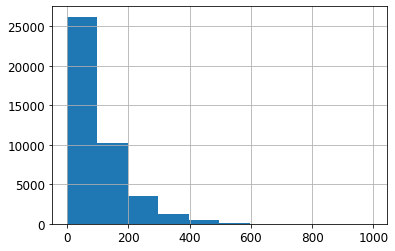

In [0]:
pm25["pm2.5"].hist()

In [0]:
corr_matrix = pm25.corr()
corr_matrix["pm2.5"].sort_values(ascending=False)

pm2.5    1.000000
DEWP     0.171423
day      0.082788
Is       0.019266
year    -0.014690
No      -0.017706
hour    -0.023116
month   -0.024069
PRES    -0.047282
Ir      -0.051369
TEMP    -0.090534
Iws     -0.247784
Name: pm2.5, dtype: float64

As we can see, attribute Iws and DEWP have the higher correlation with the classification label pm2.5 than other attributes. 

(The correlation coefficient ranges from –1 to 1. When it is close to 1, it means that there is a strong positive correlation; When the coefficient is close to –1, it means that there is a strong negative correlation. )

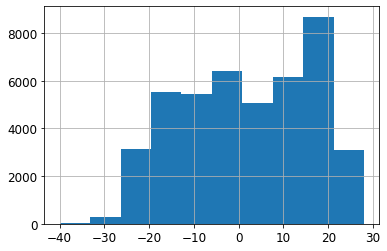

In [0]:
pm25["DEWP"].hist()

In [0]:
pm25["DEWP"].value_counts()

 18    1323
 17    1294
 19    1290
 16    1238
 20    1219
       ... 
-36       3
-37       3
-38       2
-39       1
-40       1
Name: DEWP, Length: 69, dtype: int64

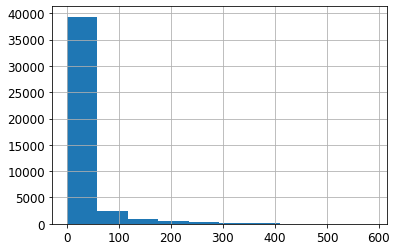

In [0]:
pm25["Iws"].hist()

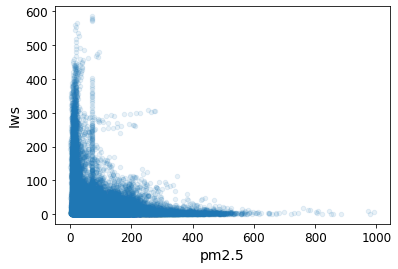

In [0]:
pm25.plot(kind="scatter", x="pm2.5", y="Iws",
alpha=0.1)

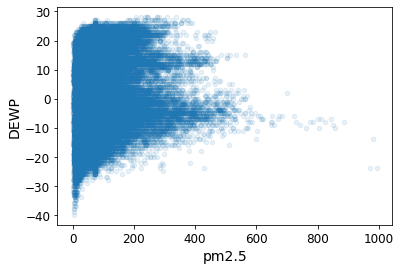

In [0]:
pm25.plot(kind="scatter", x="pm2.5", y="DEWP",
alpha=0.1)

In [0]:
pm25["DEWP_cat"] = pd.cut(pm25["DEWP"],
                               bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
                               labels=[1, 2, 3, 4, 5])

In [73]:
pm25["DEWP_cat"].value_counts()

5    18774
4     1437
2     1399
1      699
3      678
Name: DEWP_cat, dtype: int64

##**Prepare the data**
**Handle missing data**
by replacing missing data with median value

In [44]:
median = pm25["pm2.5"].median()
pm25["pm2.5"].fillna(median, inplace=True)
pm25.head()

,No,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir
0,1,2010,1,1,0,72.0,-21,-11.0,1021.0,NW,1.79,0,0
1,2,2010,1,1,1,72.0,-21,-12.0,1020.0,NW,4.92,0,0
2,3,2010,1,1,2,72.0,-21,-11.0,1019.0,NW,6.71,0,0
3,4,2010,1,1,3,72.0,-21,-14.0,1019.0,NW,9.84,0,0
4,5,2010,1,1,4,72.0,-20,-12.0,1018.0,NW,12.97,0,0


**Handling Text and Categorical Attribute**

Remove the text attribute because median can only be calculated on numerical attributes:

In [69]:
pm25_num = pm25.drop("cbwd", axis=1)
pm25_num

,No,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,Iws,Is,Ir
0,1,2010,1,1,0,72.0,-21,-11.0,1021.0,1.79,0,0
1,2,2010,1,1,1,72.0,-21,-12.0,1020.0,4.92,0,0
2,3,2010,1,1,2,72.0,-21,-11.0,1019.0,6.71,0,0
3,4,2010,1,1,3,72.0,-21,-14.0,1019.0,9.84,0,0
4,5,2010,1,1,4,72.0,-20,-12.0,1018.0,12.97,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
43819,43820,2014,12,31,19,8.0,-23,-2.0,1034.0,231.97,0,0
43820,43821,2014,12,31,20,10.0,-22,-3.0,1034.0,237.78,0,0
43821,43822,2014,12,31,21,10.0,-22,-3.0,1034.0,242.70,0,0
43822,43823,2014,12,31,22,8.0,-22,-4.0,1034.0,246.72,0,0


**Create a Test Set**

In [0]:
np.random.seed(42) # to make this notebook's output identical at every run
import numpy as np

# For illustration only. Sklearn has train_test_split()
def split_train_test(data, test_ratio):
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

In [46]:
x_train, x_test = split_train_test(pm25, 0.2)
len(x_train)

35060

In [47]:
len(x_test)

8764

In [0]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy="median")

In [50]:
imputer.fit(pm25_num)

SimpleImputer(add_indicator=False, copy=True, fill_value=None,
              missing_values=nan, strategy='median', verbose=0)

In [51]:
imputer.statistics_

array([2.19125e+04, 2.01200e+03, 7.00000e+00, 1.60000e+01, 1.15000e+01,
       7.20000e+01, 2.00000e+00, 1.40000e+01, 1.01600e+03, 5.37000e+00,
       0.00000e+00, 0.00000e+00])

Check that this is the same as manually computing the median of each attribute:

In [52]:
pm25_num.median().values

array([2.19125e+04, 2.01200e+03, 7.00000e+00, 1.60000e+01, 1.15000e+01,
       7.20000e+01, 2.00000e+00, 1.40000e+01, 1.01600e+03, 5.37000e+00,
       0.00000e+00, 0.00000e+00])

Transform the training set:

In [0]:
X = imputer.transform(pm25_num)

In [0]:
pm25_tr = pd.DataFrame(X, columns=pm25_num.columns,
                          index=pm25.index)

In [58]:
imputer.strategy

'median'

In [0]:
pm25_tr = pd.DataFrame(X, columns=pm25_num.columns,
                          index=pm25_num.index)

In [60]:
pm25_tr.head()

,No,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,Iws,Is,Ir
0,1.0,2010.0,1.0,1.0,0.0,72.0,-21.0,-11.0,1021.0,1.79,0.0,0.0
1,2.0,2010.0,1.0,1.0,1.0,72.0,-21.0,-12.0,1020.0,4.92,0.0,0.0
2,3.0,2010.0,1.0,1.0,2.0,72.0,-21.0,-11.0,1019.0,6.71,0.0,0.0
3,4.0,2010.0,1.0,1.0,3.0,72.0,-21.0,-14.0,1019.0,9.84,0.0,0.0
4,5.0,2010.0,1.0,1.0,4.0,72.0,-20.0,-12.0,1018.0,12.97,0.0,0.0


Now let's preprocess the categorical input feature, cbwd (Combine Wind Direction):

In [61]:
pm25_cat = pm25[["cbwd"]]
pm25_cat.head(10)

,cbwd
0,NW
1,NW
2,NW
3,NW
4,NW
5,NW
6,NW
7,NW
8,NW
9,NW


In [62]:
from sklearn.preprocessing import OrdinalEncoder

ordinal_encoder = OrdinalEncoder()
pm25_cat_encoded = ordinal_encoder.fit_transform(pm25_cat)
pm25_cat_encoded[:10]

array([[1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.]])

In [63]:
ordinal_encoder.categories_

[array(['NE', 'NW', 'SE', 'cv'], dtype=object)]

In [64]:
from sklearn.preprocessing import OneHotEncoder

cat_encoder = OneHotEncoder()
pm25_cat_1hot = cat_encoder.fit_transform(pm25_cat)
pm25_cat_1hot

<43824x4 sparse matrix of type '<class 'numpy.float64'>'
	with 43824 stored elements in Compressed Sparse Row format>

By default, the OneHotEncoder class returns a sparse array, but we can convert it to a dense array if needed by calling the toarray() method:

In [65]:
pm25_cat_1hot.toarray()

array([[0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       ...,
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.]])

Let's create a custom transformer to add extra attributes:

In [0]:
from sklearn.base import BaseEstimator, TransformerMixin

# column index
TEMP_ix, PRES_ix, Is_ix, Ir_ix = 3, 4, 5, 6

class CombinedAttributesAdder(BaseEstiIrtor, TransformerMixin):
    def __init__(self, add_bedrooms_per_room = True): # no *args or **kargs
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None):
        return self  # nothing else to do
    def transform(self, X):
        rooms_per_household = X[:, rooms_ix] / X[:, households_ix]
        population_per_household = X[:, population_ix] / X[:, households_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household,
                         bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]

attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
pm25_extra_attribs = attr_adder.transform(pm25.values)

In [67]:
x_train_num, x_test_num = split_train_test(pm25_num, 0.2)
len(x_train_num)

35060

**Normalizaion/min-max scaling**

In [68]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
x_train_scaled = scaler.fit_transform(x_train_num)
print("Min:", np.min(x_train_scaled))
print("Max:", np.max(x_train_scaled))

x_test_scaled = scaler.transform(x_test_num)
print("Min:", np.min(x_test_scaled))
print("Max:", np.max(x_test_scaled))


Min: 0.0
Max: 1.0
Min: 0.0
Max: 1.0588235294117647


Now let's build a pipeline for preprocessing the numerical attributes:

In [0]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),
        #('attribs_adder', CombinedAttributesAdder()),
        #('std_scaler', StandardScaler()),
    ])

pm25_num_tr = num_pipeline.fit_transform(pm25_num)

In [85]:
pm25_labels = x_train_num["pm2.5"].copy()
pm25_labels

29205     51.0
12330    139.0
15274     14.0
13989     72.0
19823     15.0
         ...  
41670    109.0
42919    100.0
6760     435.0
38593     13.0
42478      5.0
Name: pm2.5, Length: 35060, dtype: float64

In [88]:
from sklearn.compose import ColumnTransformer

num_attribs = list(x_train_num)
cat_attribs = ["cbwd"]

full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        ("cat", OneHotEncoder(), cat_attribs),
    ])

pm25_prepared = full_pipeline.fit_transform(x_train)
pm25_prepared

array([[1.5080e+04, 2.0110e+03, 9.0000e+00, ..., 1.0000e+00, 0.0000e+00,
        0.0000e+00],
       [6.6710e+03, 2.0100e+03, 1.0000e+01, ..., 0.0000e+00, 1.0000e+00,
        0.0000e+00],
       [2.3446e+04, 2.0120e+03, 9.0000e+00, ..., 1.0000e+00, 0.0000e+00,
        0.0000e+00],
       ...,
       [3.8159e+04, 2.0140e+03, 5.0000e+00, ..., 0.0000e+00, 1.0000e+00,
        0.0000e+00],
       [8.6100e+02, 2.0100e+03, 2.0000e+00, ..., 0.0000e+00, 1.0000e+00,
        0.0000e+00],
       [1.5796e+04, 2.0110e+03, 1.0000e+01, ..., 1.0000e+00, 0.0000e+00,
        0.0000e+00]])

##**Select and train a model**

**Linear Regression**

In [89]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(pm25_prepared, pm25_labels)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [92]:
# let's try the full preprocessing pipeline on a few training instances
some_data = pm25.iloc[:5]
some_labels = pm25_labels.iloc[:5]
some_data_prepared = full_pipeline.transform(some_data)

print("Predictions:", lin_reg.predict(some_data_prepared))

Predictions: [101.80178069 101.75263051 101.79878356 101.62177909 101.60113616]


/usr/local/lib/python3.6/dist-packages/sklearn/compose/_column_transformer.py:430: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  FutureWarning)


Compare against the actual values:

In [93]:
print("Labels:", list(some_labels))

Labels: [51.0, 139.0, 14.0, 72.0, 15.0]


The predictions are not accurate (e.g., the first prediction is off by close to
50%!). Let’s measure this regression model’s RMSE on the whole training set using Scikit-Learn’s
mean_squared_error function:

In [94]:
some_data_prepared

array([[ 1.000e+00,  2.010e+03,  1.000e+00,  1.000e+00,  0.000e+00,
         7.200e+01, -2.100e+01, -1.100e+01,  1.021e+03,  1.790e+00,
         0.000e+00,  0.000e+00,  0.000e+00,  1.000e+00,  0.000e+00,
         0.000e+00],
       [ 2.000e+00,  2.010e+03,  1.000e+00,  1.000e+00,  1.000e+00,
         7.200e+01, -2.100e+01, -1.200e+01,  1.020e+03,  4.920e+00,
         0.000e+00,  0.000e+00,  0.000e+00,  1.000e+00,  0.000e+00,
         0.000e+00],
       [ 3.000e+00,  2.010e+03,  1.000e+00,  1.000e+00,  2.000e+00,
         7.200e+01, -2.100e+01, -1.100e+01,  1.019e+03,  6.710e+00,
         0.000e+00,  0.000e+00,  0.000e+00,  1.000e+00,  0.000e+00,
         0.000e+00],
       [ 4.000e+00,  2.010e+03,  1.000e+00,  1.000e+00,  3.000e+00,
         7.200e+01, -2.100e+01, -1.400e+01,  1.019e+03,  9.840e+00,
         0.000e+00,  0.000e+00,  0.000e+00,  1.000e+00,  0.000e+00,
         0.000e+00],
       [ 5.000e+00,  2.010e+03,  1.000e+00,  1.000e+00,  4.000e+00,
         7.200e+01, -2.000e+01, 

In [95]:
from sklearn.metrics import mean_squared_error

pm25_predictions = lin_reg.predict(pm25_prepared)
lin_mse = mean_squared_error(pm25_labels, pm25_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

89.72217489971109

The mean Square Error Score is clearly not a great score: most pm2.5 values
range between 0 and 200, so a typical prediction error of 89 is not very satisfying.
This is an example of a model underfitting the training data. When this happens it can mean that the
features do not provide enough information to make good predictions, or that the model is not powerful
enough.

In [96]:
from sklearn.metrics import mean_absolute_error

lin_mae = mean_absolute_error(pm25_labels, pm25_predictions)
lin_mae

66.14979405236281

In [97]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor(random_state=42)
tree_reg.fit(pm25_prepared, pm25_labels)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=42, splitter='best')

In [98]:
pm25_predictions = tree_reg.predict(pm25_prepared)
tree_mse = mean_squared_error(pm25_labels, pm25_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

0.0

0.0 means no errors at all, which is unlikely to happen. 
The model has badly overfit the data.